Bilal Shehata and Armaan Mcleoud 
--DREAM TEAM--

In [14]:
#RUN THIS CELL TO LOAD IN FUNCTIONS

#imports used for program

import itertools
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import csv
from pprint import pprint
from collections import defaultdict
from random import shuffle
from sklearn.metrics import confusion_matrix


# This function should open a data file in csv, and transform it into a usable format 

def k_fold(fulldf):
    #split array into 10 pieces
    karrays = np.array_split(fulldf,K)
  
    counter = 0 
    sum = 0 #record results
    
    for i in range(0,len(karrays)):
        counter = 0
        testdf = karrays[i] #set the test array as one of the chunks
        
       
        for j in range(0,len(karrays)):
            #ensure that were not adding the test chunk to the array 
            if i != j: 
                
               if counter == 0:
                   counter+=1
                   traindf = karrays[j] #initialise the data to be trained
                   continue 
               #concatinate all the chunks that arent the test chunk
               traindf = pd.concat([traindf,karrays[j]],axis = 0) 
        
        #train the classifer by building the probability dictionary 
        probs, classes, priors = train_supervised(traindf)
        #evaluate the classifier 
    
        sum+= evaluate_supervised(testdf, probs, classes,priors)
        
    return sum/K       

#determinisatically decide classes for instances 
def deterministic_preprocess():
    #load in the dataframe 
     df = pd.read_csv(filepath, header = None)
    
     clean(df) #impute missing values if they exist
     df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe
     classes = df[len(df.columns)-1].unique()
    #remove classes from the data 
     df = df.iloc[:, :-1]
    
    
    #randomly select a class for the instance 
     df[len(df.columns)-1] = np.random.choice(classes, df.shape[0])
     
    
   
   
     return df, classes
    
#preprocessing for supervised classifier 
def preprocess():
    
    
    #load in data 
    df = pd.read_csv(filepath, header = None)

    clean(df) #impute missing values if they exist
    df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe
  
    
    return df

               
           
def train_supervised(df):
    
    #prior probabilties
    highProb = df.groupby(len(df.columns)-1).size().div(len(df))
     
    #probabiltiy deictionary 
    probList = defaultdict(lambda: defaultdict(float))
    
    #this loop calculates the probabilties 
    for i in range(0,len(df.columns)-1):
        cols =[len(df.columns)-1,i]
       
        trained = df.groupby(cols).size().div(len(df)).multiply(highProb, axis = 0,level=(len(df.columns)-1))
        
        probList[i] = trained
    
    #converts dataframe into dictionary 
    for i in range(0,len(probList)):
        probList[i] = probList[i].to_dict()
        #collects the classes into an list
    classes = df[len(df.columns)-1].unique()
    
    priors = get_super_priors(df,classes)
    
    return probList, classes, priors

def evaluate_supervised(testcsv, probs,classes,priors):

    correct = 0
    total = 0 
    #iterate over each of the rows and pass it to the predict supervised method
    for index, testrow in testcsv.iterrows() :
        
        #if the prediction is correct increase the counter 
        if predict_supervised(probs, testrow.tolist(),classes,priors) == testrow[len(testcsv.columns)-1]:
            
            correct +=1
     
        total +=1
        
     #return the accuracy of the classifier 
    return correct/total
            
#cleaning methiod removes '?' and places in it the most common value for that column
def clean(dataframe):
    #find all ? values and impute the most common value for that attribute 
    for index, testrow in dataframe.iterrows():
      for i in range(0,len(testrow)):
          if testrow[i] == '?':
              testrow[i] = dataframe[i].value_counts().idxmax()
              dataframe.loc[index,dataframe.columns[i] ] = testrow[i]
  
    return dataframe
     

    
    #train the data
  

#function is used for preprocessing the data for unsupervised method 
def unsupervised_preprocess():
      df = pd.read_csv(filepath, header = None)
      
      df = clean(df) #impute missing values if they exist
      df = df.sample(frac=1).reset_index(drop=True) #shuffles the dataframe
      classes = sorted(df[len(df.columns)-1].unique()) #returns the set of classes from dataframe
   
      df = df.iloc[:, :-1] #for unsupervised method the classes are cropped off the dataframe 
      #for each row and class assign a random value to the classes
      for probable_class in classes:
          df[probable_class] = pd.Series(np.random.rand(len(df)))
      #ensure that the values are normalised
      normalise_unsupervised(df,classes)
      
   
      return df, classes
#function is used to normalise the distributions of the pandas file in the dataframe     
def normalise_unsupervised(df, classes):
    #iterate through the rows
    for index, row in df.iterrows():
        #iterate through the attributes which are classes
        total = sum(row[-len(classes):])
        for i in range((len(row)-len(classes)),len(row)):
            temp= float(row[i])/total
            df.loc[index,df.columns[i] ] = temp
      
   
    return

#function to return the prior probablities in the supervised method
def get_super_priors(df,classes):
    priors = [0.0] * len(classes)
    total = 0
    classes = classes.tolist()
    for index, row in df.iterrows():
        priors[classes.index(row[len(row)-1])] += 1 
        total += 1
    for i in range(len(priors)):
        priors[i] = priors[i]/total

           
      
   
    return priors


    

# This function should build an unsupervised NB model 
def train_unsupervised(df, classes):
   
    #collect priors 
    priors= get_priors(df,classes)
    
    #this value indictates the number of iterations  
    iterations = 4
    for i in range(1,iterations): 
       #create the initial dictionary 
        probList = make_probability_dictionary(df,classes)
        #use divide the values by fractional values 
        probList = factional_divide(df,classes,probList)
        #reassign the distrubitions 
        df = assign_distro(df,classes,probList,priors)

    
    return probList, classes, priors


#this function edits the probablity dictionary by fractionally diving the value s
def factional_divide(df,classes,probList):
    #get the fractional totals 
    fraccounts = get_fraccounts(df,classes)
    #for every attribute
    for i in probList.keys():
        #for every class
        for classtype in probList[i].keys():
            #for every attribute value 
            for value in probList[i][classtype].keys():
                    #divide the probability by the fractional count for that probabily 
                    probList[i][classtype][value] = probList[i][classtype][value] / fraccounts[classes.index(classtype)]

    return probList

#creates a list of fractional counts 
def get_fraccounts(df,classes):
    fraccounts = []
    for i in classes:   
        #add the sum of each class column to list 
        fraccounts.append(sum(df[i]))
    
    return fraccounts
#this function builds a probability dictionary 
def make_probability_dictionary(df,classes):
    
     probList = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda:0.00000001)))
     
     for prob_class in range(0,len(classes)):
        for index, row in df.iterrows() :
            for i in range(0,len(row)-len(classes)):
                probList[i][classes[prob_class]][row[i]] +=row[len(row)-len(classes)+prob_class]
     return probList

#assigns the distrobution for unsupervised instances 
def assign_distro(df,classes,probList,classProbs):
     for index, row in df.iterrows():
       
       #iterate through the instances assigning new values for each class 
       for probable_Class in range(len(classes)):
           
           product = 1 * classProbs[probable_Class]
           
           for attrib in range((len(row)-len(classes))):    
              
               product = product *probList[attrib][classes[probable_Class]][row[attrib]]
               
           df.loc[index,df.columns[(len(row)-len(classes) + probable_Class)]] = product
    #normalise the values so they add to 1 
     normalise_unsupervised(df,classes)
     
     return df

#returns the values for the prior probablities 
def get_priors(df,classes):
    classProbs = []
    #create a list for the probablities for each of the classes 
    for i in classes:   
        
        classProbs.append(sum(df[i])/len(df))
    
    return classProbs
#class makes predicitons for supervised method 
def predict_supervised(probList,testrow,classes,priors):
    
    classChance = [0.0] * len(classes)#keep record of all classchanes for this row
    classlist = classes.tolist()
    for possibleClass in classes : 
        #multiple the prior probablity 
        prob =1 *priors[classlist.index(possibleClass)]
        for i in range(0,len(testrow)-1) : #for every element multiply in its conditional probablity 
  
            if (possibleClass,testrow[i]) in probList[i]: 
                #multiply in condition probability 
                prob = prob * probList[i][(possibleClass,testrow[i])]
            else : 
               
                prob = prob * 0.00000000000001 #epsilon 
        
        classChance[classlist.index(possibleClass)]= prob
        
        

            #here we get the highest probability and match it to the class
    
    #the class with the highest probablity is what is predicted  
    return classes[classChance.index(max(classChance))]

# This function should predict the class distribution for a set of instances, based on a trained model
def predict_unsupervised(probList,testrow,classes,priors):
    
    shuffle(classes)  
    classChance = [0.0] * len(classes)#keep record of all classchanes for this row
    classlist = classes
    for possibleClass in classes : 
        #multiply in prior probability  
        prob =1 *priors[classlist.index(possibleClass)]
        for i in range(0,len(testrow)-len(classes)) : #for every element multiply in  its conditional probability 
  
            if testrow[i] in probList[i][possibleClass]: 
                  #multiply in the condition probablity 
                prob = prob * probList[i][possibleClass][testrow[i]]
            else: 
               
               prob = prob * 0.0000000001 #epsilon 
        classChance[classlist.index(possibleClass)]= prob
        
        

    
    return classes[classChance.index(max(classChance))]
  
#uses confusion matrix to evaluate unsupervised classifier
def evaluate_unsupervised(testcsv, probs, classes,priors):
    
    
    correct = 0
    total = 0 
    guesses = list()
    trues = list()
    #iterate over each of the rows and pass it to the predict supervised method
    for index, testrow in testcsv.iterrows() :
        
            
        #correct predictions increase the correct count
        if predict_unsupervised(probs, testrow.tolist(),classes,priors) == testrow[len(testcsv.columns)-1]:
            
            correct +=1
        #add the guesses to a list
        guesses.append(predict_unsupervised(probs, testrow.tolist(),classes,priors))
        #add the true values to a list 
        trues.append(testrow[len(testcsv.columns)-1])
        
        total +=1
    #this section generates a confusion matrix ----------------
    cm = confusion_matrix(trues, guesses, labels=classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #normalise the values 
    plt.imshow(cm,cmap= plt.cm.Greens) #use the green colour scheme 
  
    plt.colorbar() #add the colour bar 
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks,classes, rotation=45)
    plt.yticks(tick_marks, classes)

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate('%.4f' % cm[x][y], xy=(y, x), #show 4 digits after decimal 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # ------------------------------------------------------------
        
    #return the confusion matrix 
    return  confusion_matrix(trues, guesses)


    


Question 1: 

The unsuperivsed niave bayes (NB) has no concept of "classes" and therefore the classes can sometime end up "swapped" therefore reducing the overall accuracy for that unsupervised NB instance. Another factor which effects the the accuracy of the classifier is the proportion of nominal attributes compared to the number of instances. The reason why the unsupervised NB works at all is because we initially generated non-uniform data which is similar to the non-uniform data provided. 



0.8044066962087641


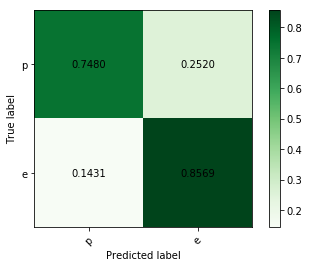

In [17]:
filepath = "./datasets/mushroom-dos.csv"

#driver made to preprocess train and evaluate an unsupervised classifier
def unsuper_driver():
    unsuper_df, classes = unsupervised_preprocess()
    probList, classes, priors = train_unsupervised(unsuper_df, classes)
    testdf = pd.read_csv(filepath, header = None)
   

    cm = evaluate_unsupervised(testdf,probList,classes,priors)
    totaltrue = 0
    total = 0
    #calculate accuracy for classifier 
    for row in cm.transpose():
        totaltrue = totaltrue + max(row)
        total = total + sum(row)
    print(totaltrue/total)
unsuper_driver()

#print(str(unsuper_driver()*100)+'%' + " Accuracy for unsupervised algorithm")


Question 2:

The performance of the supervised classifier tends to work better with more instances (rows) in the dataset. This however is not the case between "breast-cancer" and "cars" datasets, however this variation could be due to cars having a higher number of classes which causes its accuracy to be lower despite having more instances overall. 

furthermore another accuracy influence could be due to the higher number of nominal attributes allows the classifier to be more accurate. This could be explained by the classifiers ability to be more specific due to the higher number of attributes. For example the chance of a combination of 22 attributes occuring twice in the same dataset is low, therefore the classifier will most likely recognise the class of the instance with those attributes if it needs to predict it since there will be few other options that match.


In [92]:
filepath = "./datasets/car-dos.csv"
#driver made to preprocess train and evaluate a  supervised
def simple_driver():

    df = pd.read_csv(filepath, header = None)
  
    probs, classes, priors = train_supervised(df)
    
    return evaluate_supervised(df, probs,classes,priors)
print(str(simple_driver()*100)+'%' + " Accuracy for supervised algorithm")


70.02314814814815% Accuracy for supervised algorithm


Question 3:

The accuracy of testing using k-fold cross-validation method was quite close to the accuracy of testing on training data. As the number of K increases the accuracy converges with that of Training on test data. However the processing time also increases exponentially and therefore there is a tradeoff between accuracy rating and CPU time. This is most prominent when using the "Hold one" method where K is the datasets size less 1. Where the accuracies are equal however the training time is unfeasible for lager datasets. 




In [93]:
K  = 10 # k is the number of pieces to divide the data into must be atleast 2

filepath = "./datasets/car-dos.csv"



def driver():
    fulldf = preprocess()
    
    return k_fold(fulldf)
print(str(driver()*100)+'%' + " Accuracy for supervised algorithm using k-fold cross validation")
    
    
def non_kfold_driver():

    df = pd.read_csv(filepath, header = None)
  
    probs, classes,priors = train_supervised(df)
    
    return evaluate_supervised(df, probs,classes,priors)
print(str(non_kfold_driver()*100)+'%' + " Accuracy for supervised algorithm without using cross validation")

print("quite close in accuracy")

70.01747546713268% Accuracy for supervised algorithm using k-fold cross validation
70.02314814814815% Accuracy for supervised algorithm without using cross validation
quite close in accuracy


Question 4:

By deterministically assigning a random class to each instance. The accuracy will converge to 1/classes as instances increase. In contrast, if you instead assign a non-uniform distribution to each instance, through iterations the data's distrubution will become closer to the distrubution of the original dataset and therefore has potential to be much higher accuracy than the deterministic approach that is 1/classes. 


In [20]:

filepath = "./datasets/hypothyroid-dos.csv"

def deterministic_driver():
    df, classes = deterministic_preprocess()
  
    probs, classes,priors = train_supervised(df)
    
    return evaluate_supervised(df, probs,classes,priors)

print(str(deterministic_driver()*100)+ "%" + " Accuracy for unsupervised deterministic algorithm without using cross validation")

filepath = "./datasets/car-dos.csv"

print(str(deterministic_driver()*100)+ "%" + " Accuracy for unsupervised deterministic algorithm without using cross validation")

filepath = "./datasets/breast-cancer-dos.csv"

print(str(deterministic_driver()*100)+ "%" + " Accuracy for unsupervised deterministic algorithm without using cross validation")

print("^^ trend can be identified as 1/classes")


50.93265886816314% Accuracy for unsupervised deterministic algorithm without using cross validation
27.256944444444443% Accuracy for unsupervised deterministic algorithm without using cross validation
53.14685314685315% Accuracy for unsupervised deterministic algorithm without using cross validation
^^ trend can be identified as 1/classes
